In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering,_agglomerative
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score
from utils import standardize, normalize
from sklearn.decomposition import PCA

import json

## Loading the Data

In [3]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_sample_5000.csv')
print(df.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

(5000, 23)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
2,fo_order_id,object,0,df_orders,FK
3,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
4,fo_order_status,object,0,df_orders,
5,fo_order_purchase_timestamp,object,0,df_orders,
6,fo_order_approved_at,object,0,df_orders,
7,fo_order_delivered_carrier_date,object,0,df_orders,
8,fo_order_delivered_customer_date,object,0,df_orders,
9,fo_order_estimated_delivery_date,object,0,df_orders,


## Create df_numeric
### Only using the numerical features in the data

In [4]:
df_numeric = df.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix'])

# df_numeric = df_numeric.sample(1000, random_state=42)
print(df_numeric.shape)
df_numeric.head()

(4843, 10)


,repeater,recency,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
0,0,376,2,403.81,1,1,-10.0,4.0,0.0,0
1,0,351,1,95.11,1,1,0.0,4.0,0.0,0
2,0,336,1,75.42,1,1,-12.0,4.0,0.0,0
3,0,477,1,148.06,1,1,-12.0,3.0,0.0,0
4,0,252,0,58.62,1,1,-9.0,3.0,0.0,1


## Linkage
### Using four different linkage methods(ward, complete, average, single)
### Using three different metrics (euclidean, cosine, cityblock/manhattan, correlation)
#### - The method ward can only be used with euclidean distance metric
### The dendograms are printed for each linkage method and metric
#### - Graphs may take a few minutes to load

In [5]:
def plot_dendrogram(df, method, metric):
    linkage_data = linkage(df, method=method, metric=metric)
    dendrogram(linkage_data)
    plt.title(f'Dendrogram of {method.capitalize()} Method Using {metric.capitalize()} Distance')
    plt.show()

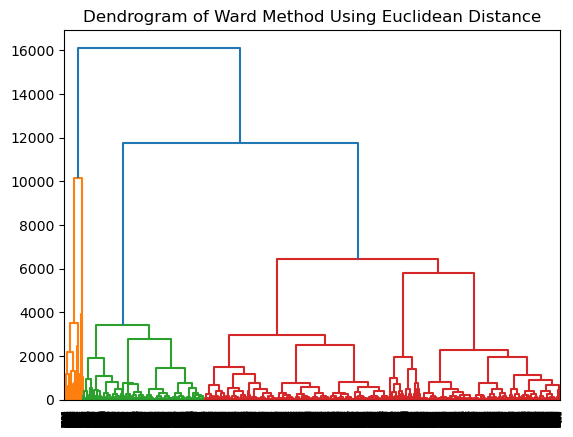

In [6]:
## ward linkage
plot_dendrogram(df_numeric, 'ward', 'euclidean')

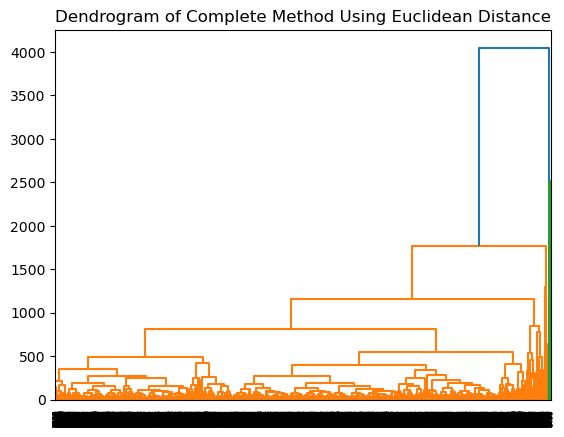

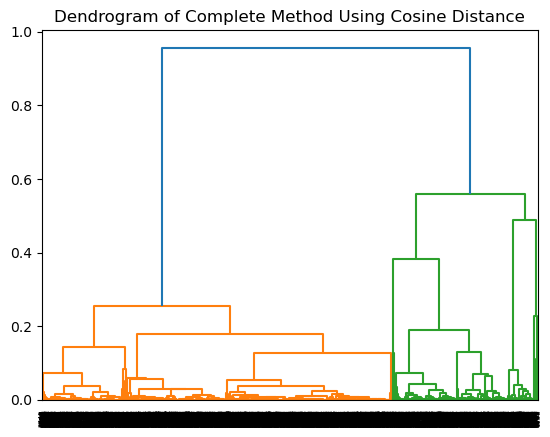

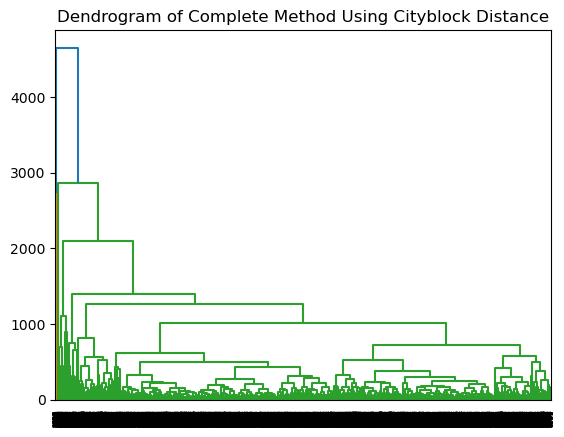

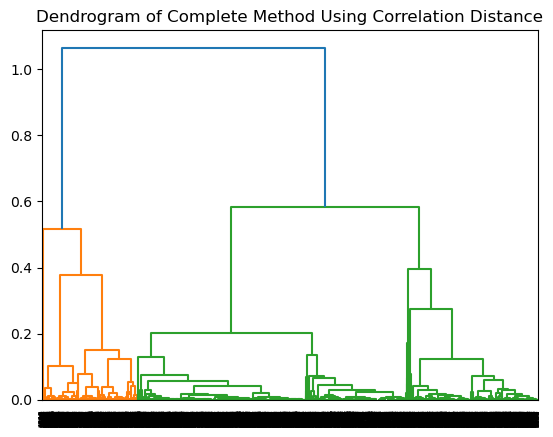

In [7]:
## complete linkage
plot_dendrogram(df_numeric, 'complete', 'euclidean')
plot_dendrogram(df_numeric, 'complete', 'cosine')
plot_dendrogram(df_numeric, 'complete', 'cityblock')
plot_dendrogram(df_numeric, 'complete', 'correlation')

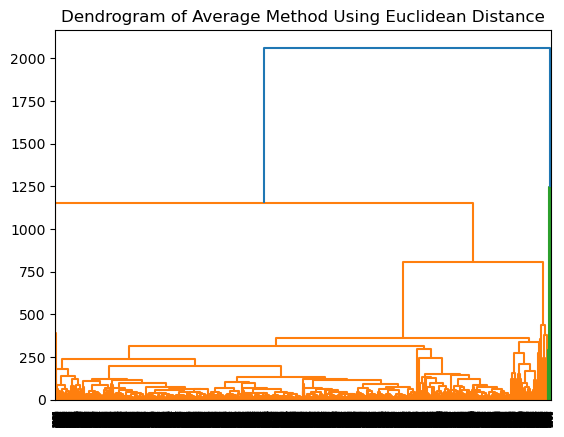

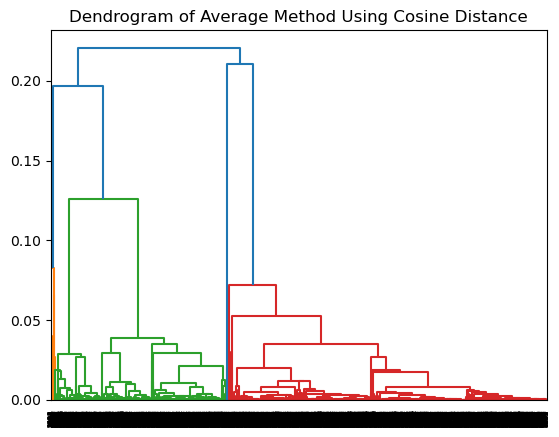

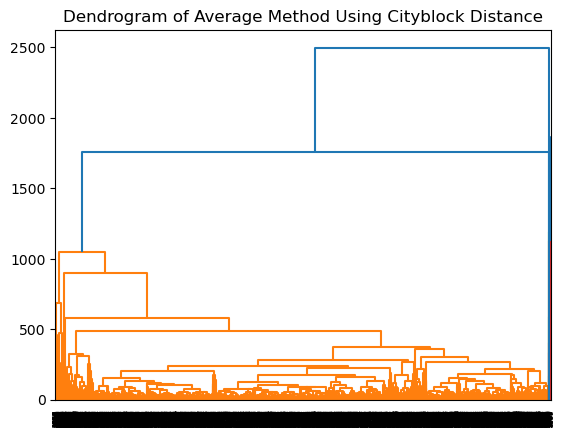

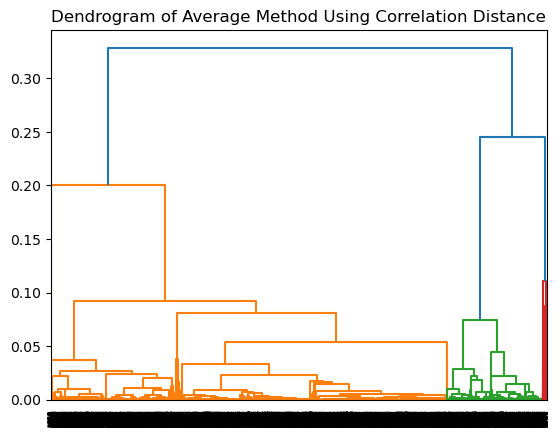

In [8]:
# average linkage
plot_dendrogram(df_numeric, 'average', 'euclidean')
plot_dendrogram(df_numeric, 'average', 'cosine')
plot_dendrogram(df_numeric, 'average', 'cityblock')
plot_dendrogram(df_numeric, 'average', 'correlation')

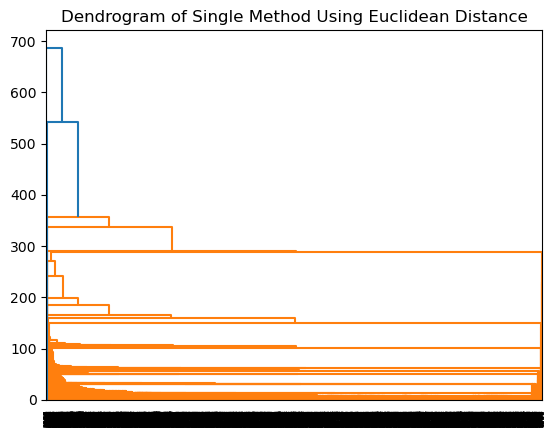

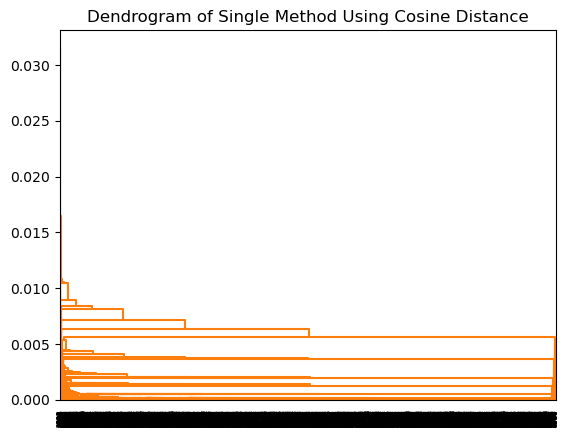

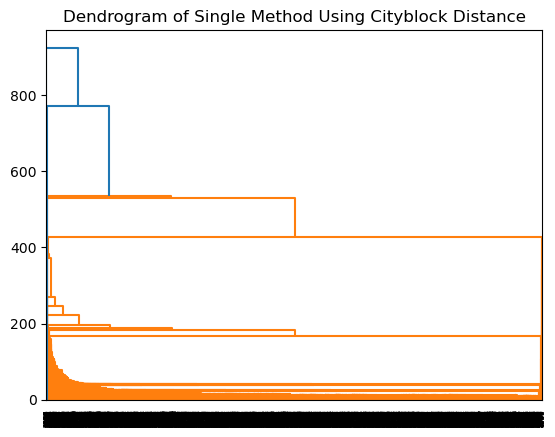

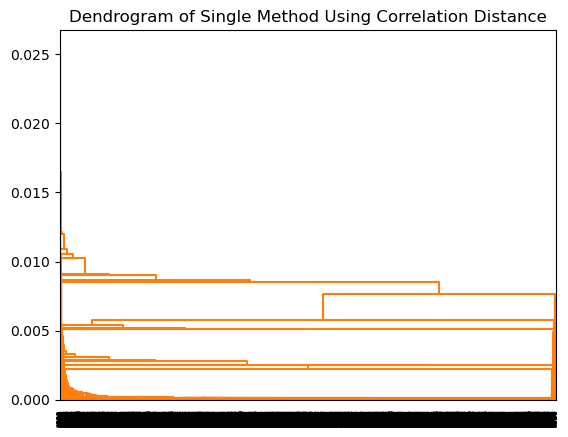

In [9]:
## single linkage
plot_dendrogram(df_numeric, 'single', 'euclidean')
plot_dendrogram(df_numeric, 'single', 'cosine')
plot_dendrogram(df_numeric, 'single', 'cityblock')
plot_dendrogram(df_numeric, 'single', 'correlation')

## Perform Agglomerative Clustering and find Silhouette Score and Davies-Bouldin Index
### Find the optimal number of clusters
### Use agglomerative clustering with different metrics and linkage and find silhouette score and Davies-Bouldin index

### Original Data

In [10]:
results = []

def perform_clustering(df, linkage, metric, distance_threshold=400):
    cluster_complete = AgglomerativeClustering(n_clusters=None, metric=metric, linkage=linkage, compute_full_tree=True, distance_threshold=distance_threshold)
    cluster_complete.fit_predict(df)
    optimal_cluster_complete = 1+np.amax(cluster_complete.labels_)
    print(f"Number of clusters for {linkage} using {metric} = {optimal_cluster_complete}")


    if optimal_cluster_complete > 1:
        clustering_complete = AgglomerativeClustering(n_clusters= optimal_cluster_complete, metric=metric,linkage=linkage, distance_threshold=None).fit(df)
        labels_complete = clustering_complete.labels_
        silhouette = silhouette_score(df, labels_complete)
        davies_bouldin = davies_bouldin_score(df, labels_complete)
        print(f"Silhouette score for {linkage} using {metric}: {silhouette}")
        print(f"Davies-Bouldin index for {linkage} using {metric}: {davies_bouldin}")
        print()
        results.append([linkage, metric, optimal_cluster_complete, silhouette, davies_bouldin])
    else:
        print(f"Silhouette score for {linkage} using {metric}: 'N/A'")
        print(f"Davies-Bouldin index for {linkage} using {metric}: 'N/A'")
        print()
        results.append([linkage, metric, optimal_cluster_complete, 'N/A', 'N/A'])


In [11]:
# ward linkage
perform_clustering(df_numeric, 'ward', 'euclidean')

# complete linkage
perform_clustering(df_numeric, 'complete', 'euclidean')
perform_clustering(df_numeric, 'complete', 'cosine')
perform_clustering(df_numeric, 'complete', 'cityblock')
perform_clustering(df_numeric, 'complete', 'correlation')

# average linkage
perform_clustering(df_numeric, 'average', 'euclidean')
perform_clustering(df_numeric, 'average', 'cosine')
perform_clustering(df_numeric, 'average', 'cityblock')
perform_clustering(df_numeric, 'average', 'correlation')

#single linkage
perform_clustering(df_numeric, 'single', 'euclidean')
perform_clustering(df_numeric, 'single', 'cosine')
perform_clustering(df_numeric, 'single', 'cityblock')
perform_clustering(df_numeric, 'single', 'correlation')

results_df = pd.DataFrame(results, columns=['Linkage', 'Distance Metric', 'Clusters', 'Silhouette Score', 'Davies-Bouldin Score'])
results_df


Number of clusters for ward using euclidean = 78
Silhouette score for ward using euclidean: 0.26055577418293735
Davies-Bouldin index for ward using euclidean: 0.8515462186584054

Number of clusters for complete using euclidean = 25
Silhouette score for complete using euclidean: 0.3403673887165685
Davies-Bouldin index for complete using euclidean: 0.6540846093603401

Number of clusters for complete using cosine = 1
Silhouette score for complete using cosine: 'N/A'
Davies-Bouldin index for complete using cosine: 'N/A'

Number of clusters for complete using cityblock = 46
Silhouette score for complete using cityblock: 0.25925150162760435
Davies-Bouldin index for complete using cityblock: 0.7287697673694179

Number of clusters for complete using correlation = 1
Silhouette score for complete using correlation: 'N/A'
Davies-Bouldin index for complete using correlation: 'N/A'

Number of clusters for average using euclidean = 11
Silhouette score for average using euclidean: 0.6446943235564921


,Linkage,Distance Metric,Clusters,Silhouette Score,Davies-Bouldin Score
0,ward,euclidean,78,0.260556,0.851546
1,complete,euclidean,25,0.340367,0.654085
2,complete,cosine,1,N/A,N/A
3,complete,cityblock,46,0.259252,0.72877
4,complete,correlation,1,N/A,N/A
5,average,euclidean,11,0.644694,0.705911
6,average,cosine,1,N/A,N/A
7,average,cityblock,24,0.362566,0.51673
8,average,correlation,1,N/A,N/A
9,single,euclidean,3,0.833814,0.093249


### Standardized Data

In [12]:
results = []
df_standardized = standardize(df_numeric)

def perform_clustering(df, linkage, metric, distance_threshold=400):
    cluster_complete = AgglomerativeClustering(n_clusters=None, metric=metric, linkage=linkage, compute_full_tree=True, distance_threshold=distance_threshold)
    cluster_complete.fit_predict(df)
    optimal_cluster_complete = 1+np.amax(cluster_complete.labels_)
    print(f"Number of clusters for {linkage} using {metric} = {optimal_cluster_complete}")


    if optimal_cluster_complete > 1:
        clustering_complete = AgglomerativeClustering(n_clusters= optimal_cluster_complete, metric=metric,linkage=linkage, distance_threshold=None).fit(df)
        labels_complete = clustering_complete.labels_
        silhouette = silhouette_score(df, labels_complete)
        davies_bouldin = davies_bouldin_score(df, labels_complete)
        print(f"Silhouette score for {linkage} using {metric}: {silhouette}")
        print(f"Davies-Bouldin index for {linkage} using {metric}: {davies_bouldin}")
        print()
        results.append([linkage, metric, optimal_cluster_complete, silhouette, davies_bouldin])
    else:
        print(f"Silhouette score for {linkage} using {metric}: 'N/A'")
        print(f"Davies-Bouldin index for {linkage} using {metric}: 'N/A'")
        print()
        results.append([linkage, metric, optimal_cluster_complete, 'N/A', 'N/A'])

In [13]:
## ward linkage
perform_clustering(df_standardized, 'ward', 'euclidean')

## complete linkage
perform_clustering(df_standardized, 'complete', 'euclidean')
perform_clustering(df_standardized, 'complete', 'cosine')
perform_clustering(df_standardized, 'complete', 'cityblock')
perform_clustering(df_standardized, 'complete', 'correlation')

## average linkage
perform_clustering(df_standardized, 'average', 'euclidean')
perform_clustering(df_standardized, 'average', 'cosine')
perform_clustering(df_standardized, 'average', 'cityblock')
perform_clustering(df_standardized, 'average', 'correlation')

## single linkage
perform_clustering(df_standardized, 'single', 'euclidean')
perform_clustering(df_standardized, 'single', 'cosine')
perform_clustering(df_standardized, 'single', 'cityblock')
perform_clustering(df_standardized, 'single', 'correlation')

results_df = pd.DataFrame(results, columns=['Linkage','Distance Metric', 'Clusters', 'Silhouette Score', 'Davies-Bouldin Score'])
results_df

Number of clusters for ward using euclidean = 1
Silhouette score for ward using euclidean: 'N/A'
Davies-Bouldin index for ward using euclidean: 'N/A'

Number of clusters for complete using euclidean = 1
Silhouette score for complete using euclidean: 'N/A'
Davies-Bouldin index for complete using euclidean: 'N/A'

Number of clusters for complete using cosine = 1
Silhouette score for complete using cosine: 'N/A'
Davies-Bouldin index for complete using cosine: 'N/A'

Number of clusters for complete using cityblock = 1
Silhouette score for complete using cityblock: 'N/A'
Davies-Bouldin index for complete using cityblock: 'N/A'

Number of clusters for complete using correlation = 1
Silhouette score for complete using correlation: 'N/A'
Davies-Bouldin index for complete using correlation: 'N/A'

Number of clusters for average using euclidean = 1
Silhouette score for average using euclidean: 'N/A'
Davies-Bouldin index for average using euclidean: 'N/A'

Number of clusters for average using cos

,Linkage,Distance Metric,Clusters,Silhouette Score,Davies-Bouldin Score
0,ward,euclidean,1,N/A,N/A
1,complete,euclidean,1,N/A,N/A
2,complete,cosine,1,N/A,N/A
3,complete,cityblock,1,N/A,N/A
4,complete,correlation,1,N/A,N/A
5,average,euclidean,1,N/A,N/A
6,average,cosine,1,N/A,N/A
7,average,cityblock,1,N/A,N/A
8,average,correlation,1,N/A,N/A
9,single,euclidean,1,N/A,N/A


### Normalized Data

In [14]:
results = []
df_normailzed = normalize(df_numeric)

def perform_clustering(df, linkage, metric, distance_threshold=400):
    cluster_complete = AgglomerativeClustering(n_clusters=None, metric=metric, linkage=linkage, compute_full_tree=True, distance_threshold=distance_threshold)
    cluster_complete.fit_predict(df)
    optimal_cluster_complete = 1+np.amax(cluster_complete.labels_)
    print(f"Number of clusters for {linkage} using {metric} = {optimal_cluster_complete}")


    if optimal_cluster_complete > 1:
        clustering_complete = AgglomerativeClustering(n_clusters= optimal_cluster_complete, metric=metric,linkage=linkage, distance_threshold=None).fit(df)
        labels_complete = clustering_complete.labels_
        silhouette = silhouette_score(df, labels_complete)
        davies_bouldin = davies_bouldin_score(df, labels_complete)
        print(f"Silhouette score for {linkage} using {metric}: {silhouette}")
        print(f"Davies-Bouldin index for {linkage} using {metric}: {davies_bouldin}")
        print()
        results.append([linkage, metric, optimal_cluster_complete, silhouette, davies_bouldin])
    else:
        print(f"Silhouette score for {linkage} using {metric}: 'N/A'")
        print(f"Davies-Bouldin index for {linkage} using {metric}: 'N/A'")
        print()
        results.append([linkage, metric, optimal_cluster_complete, 'N/A', 'N/A'])

In [15]:
## ward linkage
perform_clustering(df_normailzed, 'ward', 'euclidean')

## complete linkage
perform_clustering(df_normailzed, 'complete', 'euclidean')
perform_clustering(df_normailzed, 'complete', 'cosine')
perform_clustering(df_normailzed, 'complete', 'cityblock')
perform_clustering(df_normailzed, 'complete', 'correlation')

## average linkage
perform_clustering(df_normailzed, 'average', 'euclidean')
perform_clustering(df_normailzed, 'average', 'cosine')
perform_clustering(df_normailzed, 'average', 'cityblock')
perform_clustering(df_normailzed, 'average', 'correlation')

## single linkage
perform_clustering(df_normailzed, 'single', 'euclidean')
perform_clustering(df_normailzed, 'single', 'cosine')
perform_clustering(df_normailzed, 'single', 'cityblock')
perform_clustering(df_normailzed, 'single', 'correlation')

results_df = pd.DataFrame(results, columns=['Linkage','Distance Metric', 'Clusters', 'Silhouette Score', 'Davies-Bouldin Score'])
results_df

Number of clusters for ward using euclidean = 1
Silhouette score for ward using euclidean: 'N/A'
Davies-Bouldin index for ward using euclidean: 'N/A'

Number of clusters for complete using euclidean = 1
Silhouette score for complete using euclidean: 'N/A'
Davies-Bouldin index for complete using euclidean: 'N/A'

Number of clusters for complete using cosine = 1
Silhouette score for complete using cosine: 'N/A'
Davies-Bouldin index for complete using cosine: 'N/A'

Number of clusters for complete using cityblock = 1
Silhouette score for complete using cityblock: 'N/A'
Davies-Bouldin index for complete using cityblock: 'N/A'

Number of clusters for complete using correlation = 1
Silhouette score for complete using correlation: 'N/A'
Davies-Bouldin index for complete using correlation: 'N/A'

Number of clusters for average using euclidean = 1
Silhouette score for average using euclidean: 'N/A'
Davies-Bouldin index for average using euclidean: 'N/A'

Number of clusters for average using cos

,Linkage,Distance Metric,Clusters,Silhouette Score,Davies-Bouldin Score
0,ward,euclidean,1,N/A,N/A
1,complete,euclidean,1,N/A,N/A
2,complete,cosine,1,N/A,N/A
3,complete,cityblock,1,N/A,N/A
4,complete,correlation,1,N/A,N/A
5,average,euclidean,1,N/A,N/A
6,average,cosine,1,N/A,N/A
7,average,cityblock,1,N/A,N/A
8,average,correlation,1,N/A,N/A
9,single,euclidean,1,N/A,N/A


#### All the distance metrics and linkage methods for both normalized and standardized data could not form clusters.
#### The best method was the single linkage method with the euclidean distance metric, for the original data, had the highest silhouette score, meaning it was well matched to its own clusters compared to its neighbors. This method also had the lowest Davies-Bouldin Score, which means the clustering quality was better.
#### We will analyze the single linkage method with euclidean distance since it is the best model.

In [16]:
from utils import get_comparison_df

## train df_numeric again.
agglomerativeClustering = AgglomerativeClustering(n_clusters= 3, metric='euclidean', linkage='single', compute_full_tree=True, distance_threshold=None)
agglomerativeClustering.fit(df_numeric)
labels = agglomerativeClustering.labels_

## estimate the centroids
clusters = pd.DataFrame(df_numeric).assign(Cluster=labels)
centroids = clusters.groupby('Cluster').mean().reset_index()

centroids_df = pd.DataFrame(centroids, columns=df_numeric.columns)
print(f"centroids_df shape: {centroids_df.shape}")

centroids_comparison_df = get_comparison_df(df_numeric, centroids_df)
centroids_comparison_df

centroids_df shape: (3, 10)


,Feature,cl1_centroid,cl2_centroid,cl3_centroid,Data Mean,Data Median
0,repeater,0.029333,0.00,0.0,0.029321,0.00
1,recency,284.641396,134.00,477.0,284.650010,267.00
2,rfm_score,0.529643,3.00,2.0,0.530456,0.00
3,fo_payment_value,156.791432,4034.44,1224.1,157.812484,104.37
4,fo_is_daytime,0.902499,1.00,1.0,0.902540,1.00
5,fo_is_weekday,0.770915,1.00,1.0,0.771010,1.00
6,fo_delivery_delay_days,-11.930593,-21.00,-12.0,-11.932480,-12.00
7,fo_review_score_mean,4.180025,5.00,5.0,4.180363,5.00
8,fo_voucher_payment_value,3.103658,0.00,1224.1,3.355133,0.00
9,customer_in_sao_paulo,0.415617,1.00,1.0,0.415858,0.00


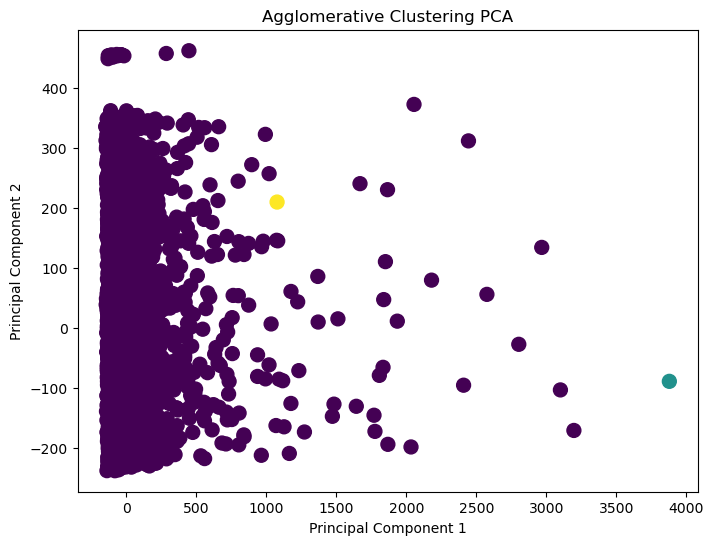

In [17]:
pca = PCA(n_components = 2 )
pca.fit(df_numeric)
df_pca = pca.transform(df_numeric)
df_pca = pd.DataFrame(df_pca, columns = ['P1', 'P2']) 

plt.figure(figsize=(8, 6))

plt.title('Agglomerative Clustering PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.scatter(df_pca.P1, df_pca.P2, c=agglomerativeClustering.labels_, s=100)

##### The visualization above shows three different clusters, which are indiicated by the different colors. The purple has the most data points, while the yellow and green only a few (or one as seen above) indicating variations in the the clusters.
##### Below is just a dendogram of the best model's top three levels

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [45.0, 45.0, 55.0, 55.0],
  [30.0, 30.0, 50.0, 50.0],
  [15.0, 15.0, 40.0, 40.0],
  [5.0, 5.0, 27.5, 27.5]],
 'dcoord': [[0.0, 93.11140209448044, 93.11140209448044, 0.0],
  [0.0, 336.45668250162606, 336.45668250162606, 0.0],
  [93.11140209448044,
   356.5009396902061,
   356.5009396902061,
   336.45668250162606],
  [0.0, 541.5684640006283, 541.5684640006283, 356.5009396902061],
  [0.0, 686.9351847882012, 686.9351847882012, 541.5684640006283]],
 'ivl': ['955', '23', '2527', '3900', '1138', '(4838)'],
 'leaves': [955, 23, 2527, 3900, 1138, 9680],
 'color_list': ['C1', 'C1', 'C1', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C0', 'C1', 'C1', 'C1', 'C1']}

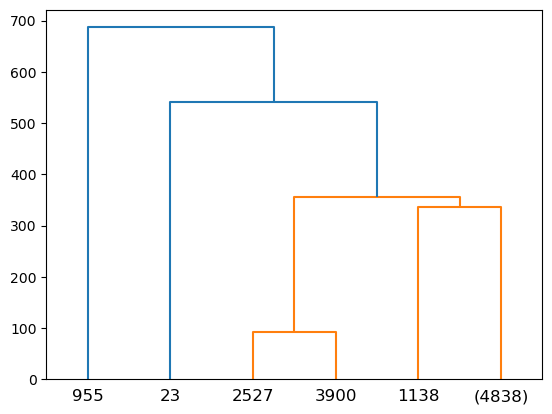

In [18]:
best_linkage = linkage(df_numeric, 'single', 'euclidean')
dendrogram(best_linkage, truncate_mode="level", p=3)